In [1]:
import aiida

# must execute it in the first place
aiida.load_profile()


In [2]:
from aiida.manage.configuration import get_profile

from aiida.common.datastructures import CalcInfo, CodeInfo
from aiida.common.folders import Folder

from aiida.engine import CalcJob, WorkChain
from aiida.engine import calcfunction, workfunction, submit, run

from aiida.plugins import DataFactory, WorkflowFactory

from aiida.parsers.parser import Parser
from aiida.orm import Code
from aiida.orm import load_code, load_node
from aiida.orm import Str, Dict, Float, Int, Bool
from aiida.orm import QueryBuilder

import aiida

from ase.io.espresso import write_espresso_in
from ase.io.lammpsdata import read_lammps_data
from ase.build import make_supercell
from ase import Atom, Atoms
import ase

from itertools import combinations_with_replacement
import numpy as np
import os
import subprocess
import shutil
import re
from time import sleep
import spglib
import json

from os.path import expanduser

from tools import NodeBank
from tools import wait_for_node_finished
from aiida_alamode.io import load_atoms
from tools.putstructure import PutStructure


In [3]:
# 型定義
StructureData = DataFactory('structure')
FolderData = DataFactory('folder')
SinglefileData = DataFactory('singlefile')
ArrayData = DataFactory('array')
List = DataFactory('list')


In [4]:
g_graph = False  # graphを作るか

CWD_DEFAULT = "run34"

# 実行root directoryの定義
if os.path.isfile("setting.json"):
    with open("setting.json") as f:
        _dic = json.load(f)
else:
    pwd = os.path.split(os.getcwd())
    _dic = {"CWD": CWD_DEFAULT}
    with open("setting.json", "w") as f:
        json.dump(_dic, f)
print(_dic)
CWD = _dic["CWD"]
_path = os.path.abspath(CWD)
os.makedirs(_path, exist_ok=True)

# 再実行時に作成したノードを用いるためにnodebankを使う。
g_force = False
nodebank = NodeBank(_path, force=g_force)

# 計算するroot directoryの定義
key = "root_wd"
g_root_wd = nodebank.load_or_dump(key, Str(os.path.join(os.getcwd(), CWD)))
os.makedirs(g_root_wd.value, exist_ok=True)
g_root_wd


{'CWD': 'run35'}
debug, node uuid: fc82cbc6-1663-4a55-82b8-d02e258e8ab4 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35
debug, load None
debug, force dump


<Str: uuid: fc82cbc6-1663-4a55-82b8-d02e258e8ab4 (pk: 3557) value: /home/max/Documents/aiida-alamode_public/example/run35>

In [5]:
# 構造ファイルの取得
# lammpsから取得する場合の例
# lammpsで最適化しているのでsimulatorもLAMMPSを用いる。
# 
# crystalを変える場合は’CWD'を変えるか、’CWD’ディレクトリを削除する。

crystal = "Si222" # Si222, GaN222
nodebank.load_or_dump("cyrstal", Str(crystal))

if crystal == "GaN222":
    g_file_format = Str("lammps-data")  # format
    _path = os.path.abspath("lammps_input/GaN/GaN222.lammps")  # file path

    _diag = np.array([2, 2, 2])
    diag = np.diag(_diag)
    g_diag = ArrayData()
    g_diag.set_array('factor', diag)  # supercellをファイルの構造の何倍にするかの定義をする
    nodebank.dump('factor', g_diag)

elif crystal == "Si222":
    g_file_format = Str("lammps-data")
    _path = os.path.abspath("lammps_input/Si222/Si222.lammps")

    _diag = np.array([2, 2, 2])
    diag = np.diag(_diag)
    g_diag = ArrayData()
    g_diag.set_array('factor', diag)  # supercellをファイルの構造の何倍にするかの定義をする
    nodebank.dump('factor', g_diag)

else:
    raise ValueError('unknow crystal.')

g_diag = nodebank.dump("diag", g_diag)
g_structure_org_filename = Str(_path)

nodebank.dump("structure_org_format", g_file_format)

g_raw_structure = load_atoms(
    g_structure_org_filename, g_file_format)
g_raw_structure.get_ase()


debug, node uuid: f3d7eb5b-029d-4695-bbc5-9a9f7ea78a22 (unstored) value: Si222
debug, load None
debug, force dump


Atoms(symbols='Si64', pbc=True, cell=[10.8, 10.8, 10.8], masses=...)

In [6]:
# structureのstandardized structure を factorで構造倍にして、formatでcwdにsaveする。
inputs = {"cwd": g_root_wd, "factor": g_diag, "format": g_file_format,
          "structure": g_raw_structure}
g_primsuper_structures = run(PutStructure, **inputs)


prim Atoms(symbols='Si2', pbc=False, cell=[[0.0, 2.7000000000000006, 2.7000000000000006], [2.7000000000000006, 0.0, 2.7000000000000006], [2.7000000000000006, 2.7000000000000006, 0.0]], masses=...)
atoms Atoms(symbols='Si2', pbc=False, cell=[[0.0, 2.7, 2.7], [2.7, 0.0, 2.7], [2.7, 2.7, 0.0]], masses=...)
path uuid: 8b78f315-6260-4102-af6e-ed482531f09f (pk: 3570) value: /home/max/Documents/aiida-alamode_public/example/run35/primcell.lammps-data
format uuid: e3b73297-2fa5-4218-a814-c1cb1ba89f47 (pk: 3560) value: lammps-data
standardized Atoms(symbols='Si8', pbc=False, cell=[5.400000000000001, 5.400000000000001, 5.400000000000001], masses=...)
atoms Atoms(symbols='Si8', pbc=False, cell=[5.4, 5.4, 5.4], masses=...)
path uuid: c911c5b3-7d8d-431d-9e1a-15b62784c1a7 (pk: 3577) value: /home/max/Documents/aiida-alamode_public/example/run35/standardizedcell.lammps-data
format uuid: e3b73297-2fa5-4218-a814-c1cb1ba89f47 (pk: 3560) value: lammps-data
atoms Atoms(symbols='Si8', pbc=False, cell=[5.4, 5

In [7]:
g_primsuper_structures  # outout


{'primstructure': <StructureData: uuid: 7239fb52-c348-4497-8086-eef440031b41 (pk: 3567)>,
 'primstructure_file': <SinglefileData: uuid: 34ef466d-f2de-4d01-a68e-0a44f5c08523 (pk: 3572)>,
 'standardizedstructure': <StructureData: uuid: 5ed8a048-b89c-4450-9b3b-01621b32cdf9 (pk: 3574)>,
 'standardizedstructure_file': <SinglefileData: uuid: d959b008-31e8-434b-85c3-59f52dc85755 (pk: 3579)>,
 'superstructure': <StructureData: uuid: 1eb2842f-97b4-4aef-8620-145bf24e0619 (pk: 3581)>,
 'superstructure_file': <SinglefileData: uuid: 6e116f84-1244-4161-a9b5-23b86c1bdb50 (pk: 3586)>}

In [8]:
# 出力構造
g_superstructure = g_primsuper_structures["superstructure"]  # StructureData
g_standardizedstructure = g_primsuper_structures["standardizedstructure"]
g_primstructure = g_primsuper_structures["primstructure"]  # StructureData
g_primstructure.get_ase(), g_standardizedstructure.get_ase(), g_superstructure.get_ase()


(Atoms(symbols='Si2', pbc=False, cell=[[0.0, 2.7, 2.7], [2.7, 0.0, 2.7], [2.7, 2.7, 0.0]], masses=...),
 Atoms(symbols='Si8', pbc=False, cell=[5.4, 5.4, 5.4], masses=...),
 Atoms(symbols='Si64', pbc=False, cell=[10.8, 10.8, 10.8], masses=...))

3574
Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 3574.dot.pdf


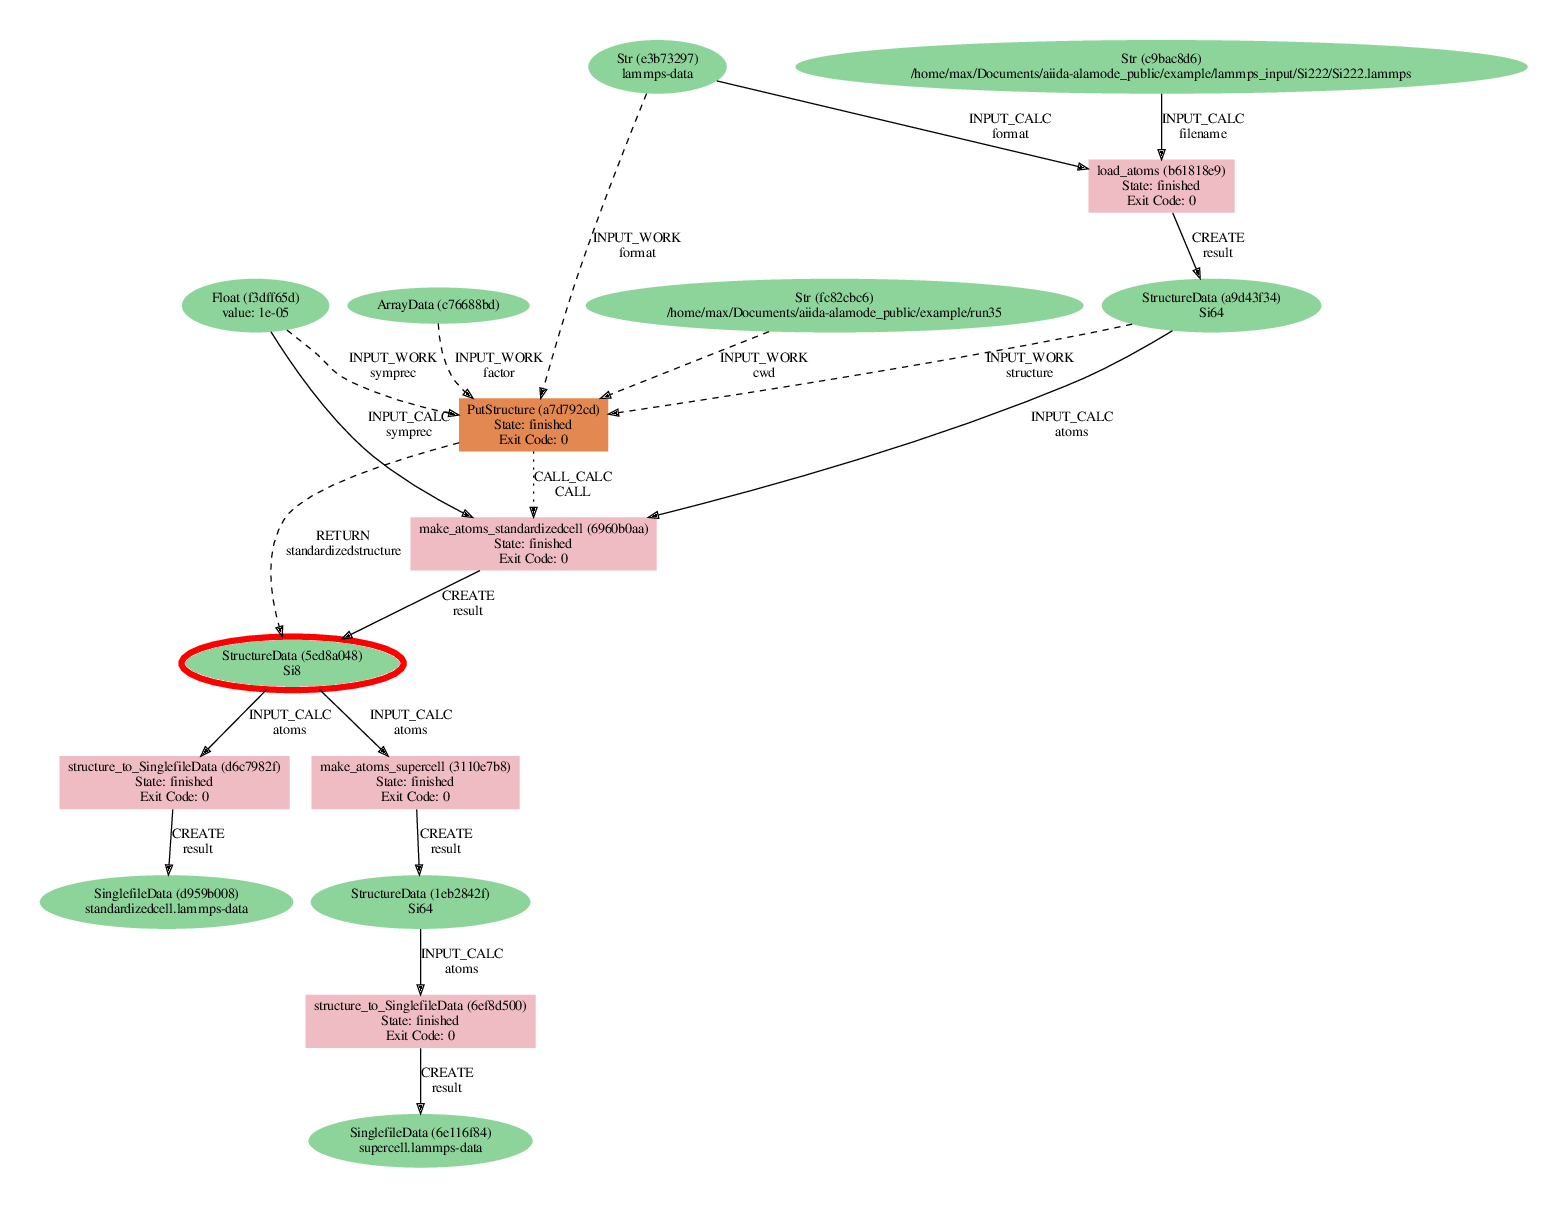

In [9]:
if True:
    pk = g_standardizedstructure.pk
    print(pk)
    !verdi node graph generate $pk
    from wand.image import Image as WImage
    filename = f"{pk}.dot.pdf"
    img = WImage(filename=filename)
    display(img)
    

In [10]:
nodebank.dump("superstructure", g_superstructure)
nodebank.dump("standardizedstructure", g_standardizedstructure)
nodebank.dump("primstructure", g_primstructure)


<StructureData: uuid: 7239fb52-c348-4497-8086-eef440031b41 (pk: 3567)>